# Contents:



*   [About Data](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)
*   [Exploratory Data Analysis](#eda)
*   [Notes](#notes)

*   [Modeling](#mod)

# Libraries:

In [60]:
!pip install contractions
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS

import contractions

import re 
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

from nltk.corpus import stopwords
from nltk.stem import  WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data:

In [62]:
path = "/content/drive/MyDrive/text.txt"


In [63]:

def read_data(file):
    data = []
    with open(file, 'r')as f:
        for line in f:
            line = line.strip()
            label = ' '.join(line[1:line.find("]")].strip().split())
            text = line[line.find("]")+1:].strip()
            data.append([label, text])
    return data

data = read_data(path)


In [64]:
def convert_label(item, name): 
    items = list(map(float, item.split()))
    label = ""
    for idx in range(len(items)): 
        if items[idx] == 1: 
            label += name[idx] + " "
    
    return label.strip()

emotions = ["joy", 'fear', "anger", "sadness", "disgust", "shame", "guilt"]

X_all = []
y_all = []
for label, text in data:
    y_all.append(convert_label(label, emotions))
    X_all.append(text)

In [65]:
df = pd.DataFrame({"text": X_all, "label":y_all})
df.head()

,text,label
0,"During the period of falling in love, each tim...",joy
1,When I was involved in a traffic accident.,fear
2,When I was driving home after several days of...,anger
3,When I lost the person who meant the most to me.,sadness
4,The time I knocked a deer down - the sight of ...,disgust


In [66]:
print("Number of instances: {}".format(len(df)))

Number of instances: 7480


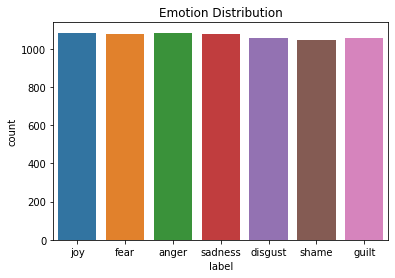

In [67]:
sns.countplot(df.label)
plt.title("Emotion Distribution");

In [68]:
df.label.value_counts(normalize = True)

joy        0.144920
anger      0.144385
sadness    0.144251
fear       0.144118
disgust    0.141310
guilt      0.141310
shame      0.139706
Name: label, dtype: float64

In [69]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [70]:
# make copy of data:
dfc = df.copy()

In [71]:
# calculate length of each text
dfc['length'] = dfc['text'].apply(lambda x : len(x))

In [72]:
# calculate number of words for each text
dfc['n_words'] = dfc['text'].apply(lambda x: len(x.split()))

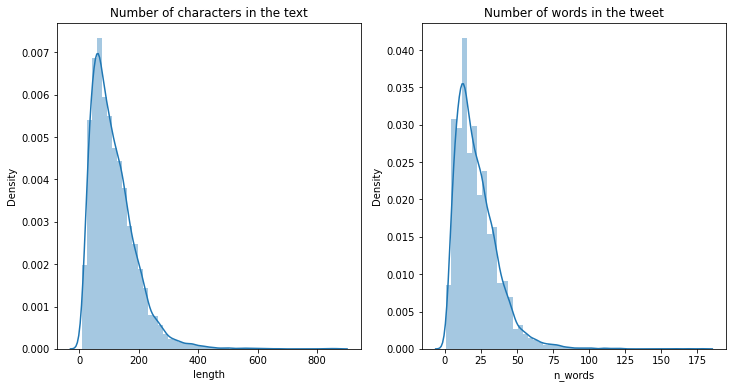

In [73]:
# Distribution of text length and word count
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
sns.distplot(dfc['length'], ax=ax1)
sns.distplot(dfc['n_words'], ax=ax2)
ax1.set_title('Number of characters in the text')
ax2.set_title('Number of words in the tweet')
plt.show()

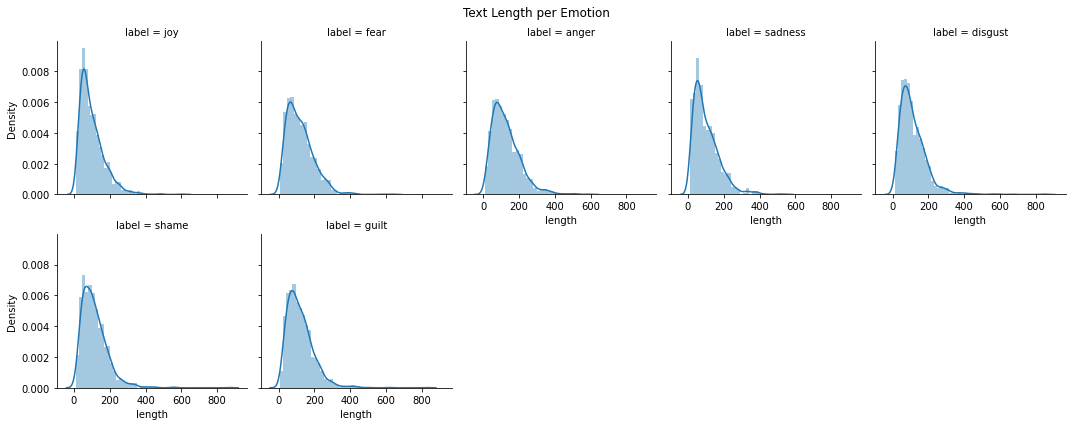

In [74]:
g = sns.FacetGrid(col = 'label', data = dfc, col_wrap= 5)
g.map(sns.distplot, 'length')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Text Length per Emotion");

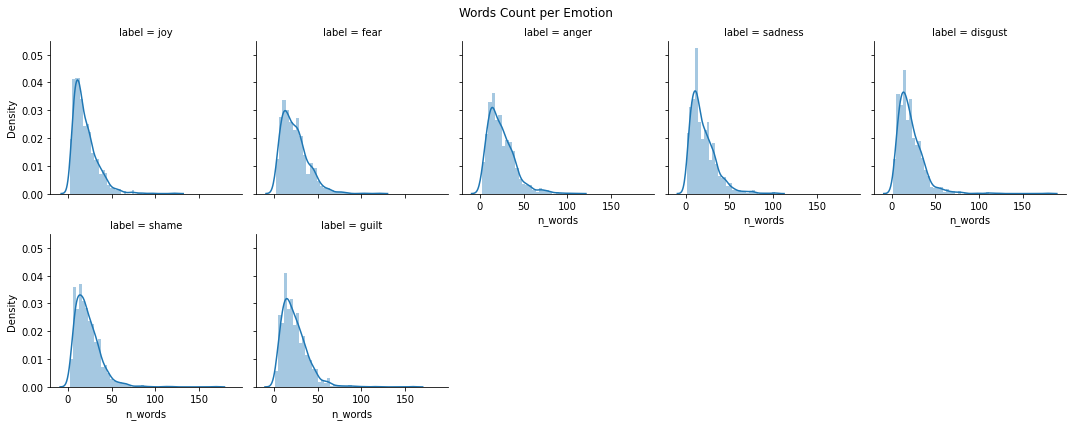

In [75]:
g2 = sns.FacetGrid(col = 'label', data = dfc, col_wrap= 5)
g2.map(sns.distplot, 'n_words')
g2.fig.subplots_adjust(top=0.9)
g2.fig.suptitle("Words Count per Emotion");

In [76]:
avg_df = dfc.groupby('label').agg({'length':'mean', 'n_words':'mean'})

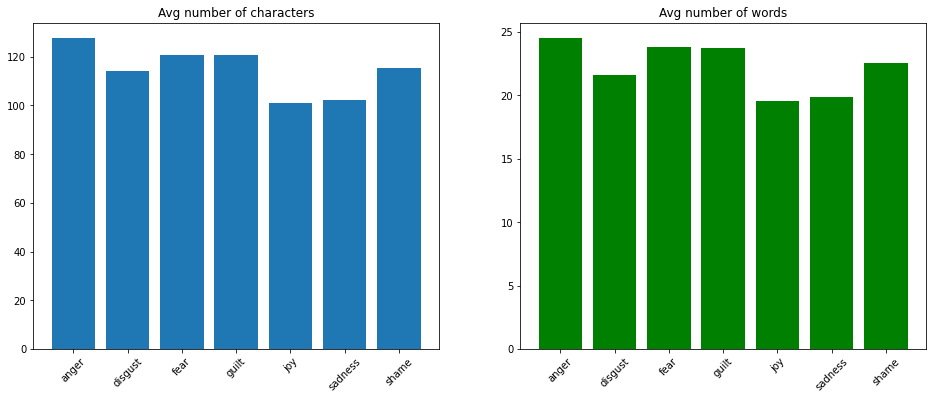

In [77]:
fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.bar(avg_df.index, avg_df['length'])
ax2.bar(avg_df.index, avg_df['n_words'], color='green')
ax1.set_title('Avg number of characters')
ax2.set_title('Avg number of words')
ax1.set_xticklabels(avg_df.index, rotation = 45)
ax2.set_xticklabels(avg_df.index, rotation = 45)
plt.show()

In [78]:
dfc.describe().T

,count,mean,std,min,25%,50%,75%,max
length,7480.0,114.433824,74.709939,8.0,60.0,98.0,152.0,863.0
n_words,7480.0,22.226604,14.712428,1.0,12.0,19.0,30.0,178.0


<a name = 'notes'></a>
**Notes:**

*   We see that our data is balanced.
*   The average length for our texts is 114 characters.
*   The average count of words for our texts is 14 word.
*   Texts that infer joy and sadness tend to be smaller than the others.





<a name = 'preproc'></a>
# Preprocessing:

In [79]:
df.text.sample(5, random_state= 40)

5063    When I took the B.A exams,I was expecting a 1s...
3549    I chatted up with a girl who I didn't love. Sh...
4416    I feel this emotion very often when I try to e...
5312                        Insulted by the class leader.
6187    I felt this emotion when my name was announced...
Name: text, dtype: object

In [80]:
lemmatizer = WordNetLemmatizer()

In [81]:
# Replace contractions in the text. For ex. didn't -> did not
dfc['text'] = dfc['text'].apply(lambda x: contractions.fix(x))

In [82]:
# Lowering:
dfc['text']= dfc['text'].apply(lambda x: x.lower())

In [83]:
# remove punctuation
dfc['text'] = dfc['text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [84]:
# remove stopwords and lemmatize
dfc['text'] = dfc['text'].apply(lambda x: " ".join(lemmatizer.lemmatize(w) for w in x.split() if w not in set(stopwords.words('english'))))


In [85]:
df.text.sample(5, random_state= 40)

5063    When I took the B.A exams,I was expecting a 1s...
3549    I chatted up with a girl who I didn't love. Sh...
4416    I feel this emotion very often when I try to e...
5312                        Insulted by the class leader.
6187    I felt this emotion when my name was announced...
Name: text, dtype: object

In [86]:
# Uni-gram analysis:
def print_word_cloud(df, sentiment):

    print("Word cloud of most frequent words for the sentiment : {}".format(sentiment))

    temp_df = df[df['label']==sentiment]
    print("Number of Rows : ", len(temp_df))

    corpus = ''
    for text in temp_df.text:
        text = str(text)
        corpus += text
        
    total = 0
    count = defaultdict(lambda: 0)
    for word in corpus.split(" "):
        total += 1
        count[word] += 1
    
        
    top20pairs = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:20]
    top20words = [i[0] for i in top20pairs]
    top20freq = [i[1] for i in top20pairs]
    
    xs = np.arange(len(top20words))
    width = 0.5

    fig = plt.figure(figsize=(10,6))                                                               
    ax = fig.gca()  #get current axes
    ax.bar(xs, top20freq, width, align='center')

    ax.set_xticks(xs)
    ax.set_xticklabels(top20words)
    plt.xticks(rotation=45)
    plt.savefig(sentiment+ str(1) +'.png')
    
    
    stopwords = set(STOPWORDS)
    # lower max_font_size, change the maximum number of word and lighten the background:
    wordcloud = WordCloud(max_font_size=50, max_words=50,stopwords=stopwords, background_color="white").generate(corpus)
    plt.figure(figsize = (12, 12), facecolor = None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(sentiment+ str(2)+'.png')
    plt.show()


Word cloud of most frequent words for the sentiment : joy
Number of Rows :  1084


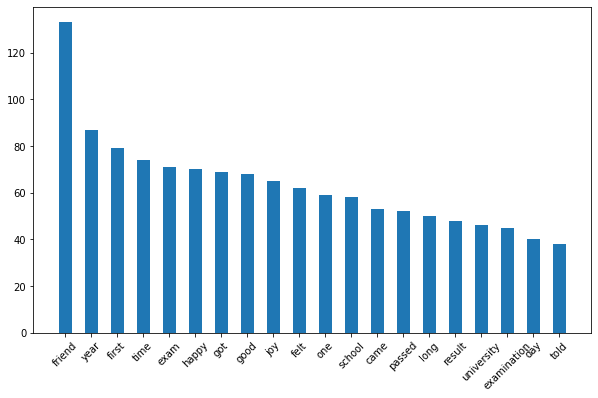

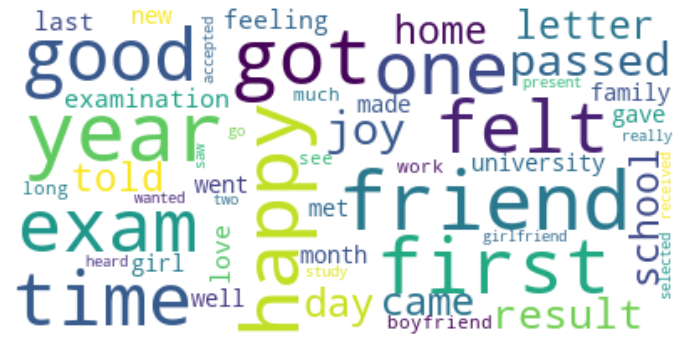

In [87]:
print_word_cloud(dfc, 'joy')

Word cloud of most frequent words for the sentiment : fear
Number of Rows :  1078


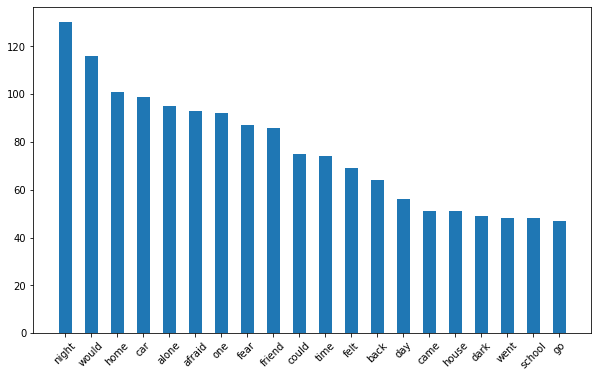

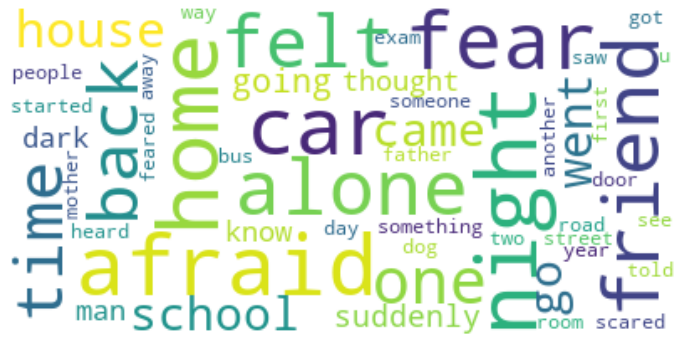

In [88]:
print_word_cloud(dfc, 'fear')

Word cloud of most frequent words for the sentiment : anger
Number of Rows :  1080


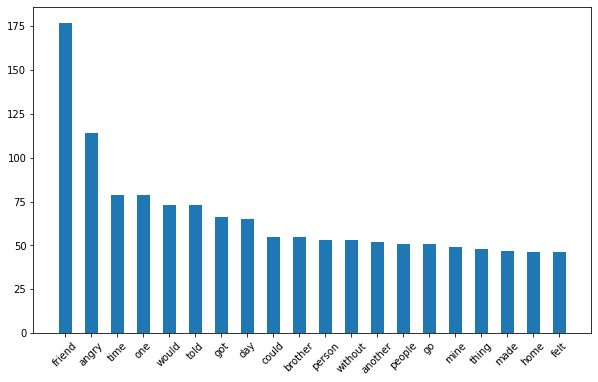

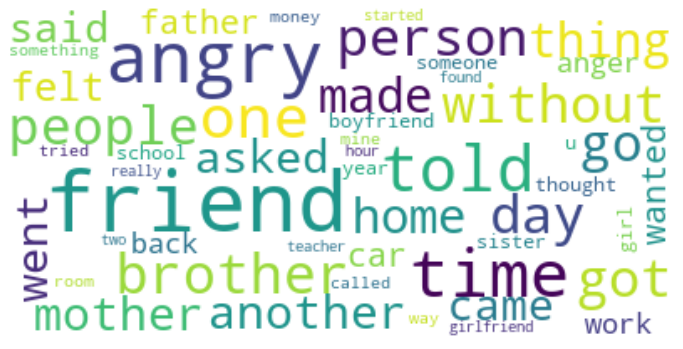

In [89]:
print_word_cloud(dfc, 'anger')

Word cloud of most frequent words for the sentiment : sadness
Number of Rows :  1079


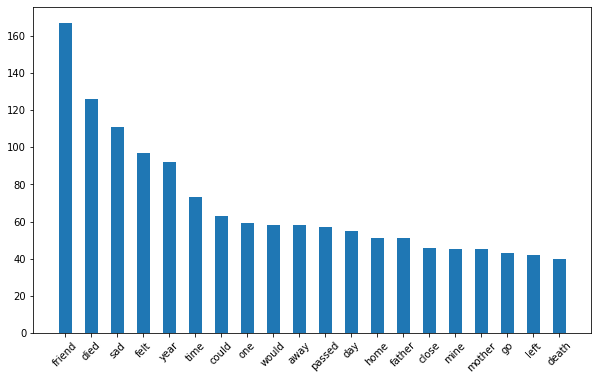

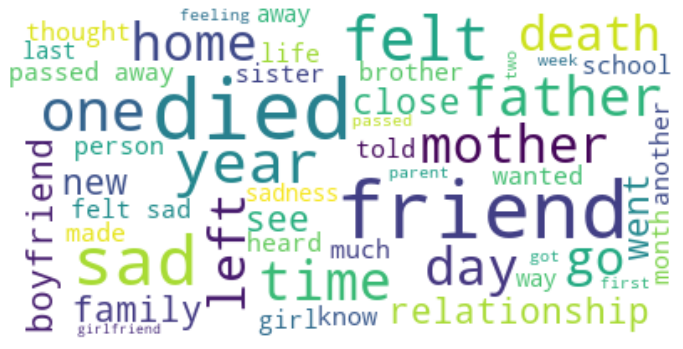

In [90]:
print_word_cloud(dfc, 'sadness')

Word cloud of most frequent words for the sentiment : disgust
Number of Rows :  1057


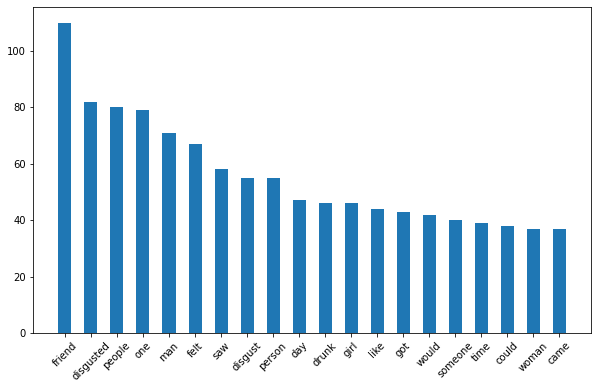

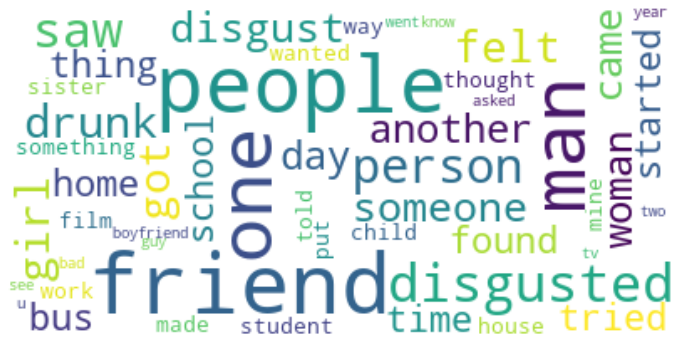

In [91]:
print_word_cloud(dfc, 'disgust')

Word cloud of most frequent words for the sentiment : shame
Number of Rows :  1045


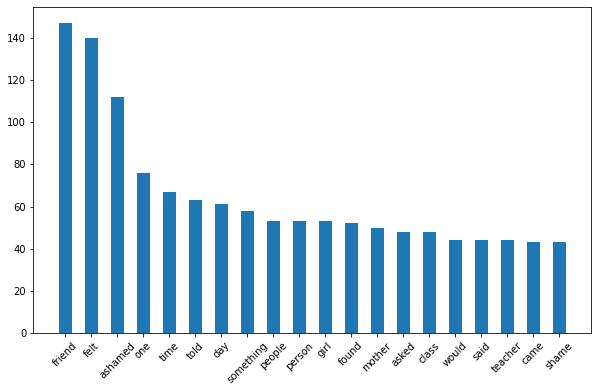

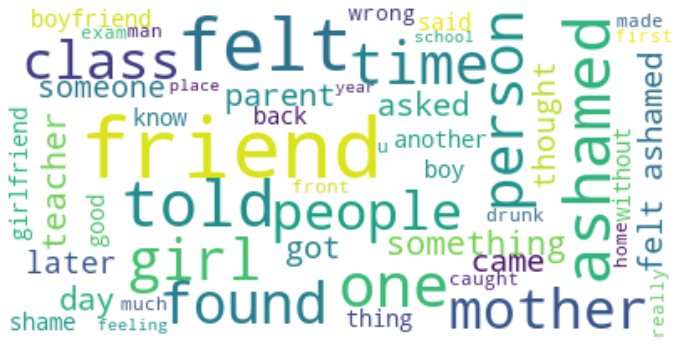

In [92]:
print_word_cloud(dfc, 'shame')

Word cloud of most frequent words for the sentiment : guilt
Number of Rows :  1057


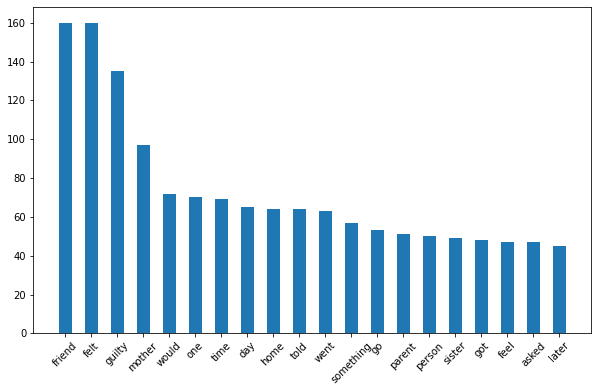

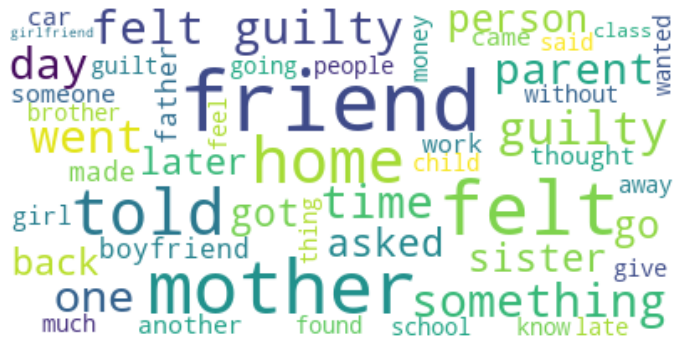

In [93]:
print_word_cloud(dfc, 'guilt')

# Splitting Data:

In [94]:
# Tokenization
#fc.text = dfc.text.apply(lambda x: x.split())
#dfc.head()

In [118]:
X = dfc['text']
y = dfc['label']

In [119]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)

In [120]:
def train_test(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    return train_acc, test_acc

In [121]:

tfidf_vec = TfidfVectorizer()
X_train = tfidf_vec.fit_transform(X_train)

X_test = tfidf_vec.transform(X_test)

In [122]:
svc = SVC()
lsvc = LinearSVC(random_state=123)
rforest = RandomForestClassifier(random_state=123)
dtree = DecisionTreeClassifier()

clifs = [svc, lsvc, rforest, dtree]

In [123]:
# train and test them 
print("| {:25} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy"))
print("| {} | {} | {} |".format("-"*25, "-"*17, "-"*13))
for clf in clifs: 
    clf_name = clf.__class__.__name__
    train_acc, test_acc = train_test(clf, X_train, X_test, y_train, y_test)
    print("| {:25} | {:17.7f} | {:13.7f} |".format(clf_name, train_acc, test_acc))

| Classifier                | Training Accuracy | Test Accuracy |
| ------------------------- | ----------------- | ------------- |
| SVC                       |         0.9751003 |     0.5601604 |
| LinearSVC                 |         0.9600602 |     0.5487968 |
| RandomForestClassifier    |         0.9969920 |     0.5427807 |
| DecisionTreeClassifier    |         0.9969920 |     0.4819519 |


In [125]:
emoji_dict = {"joy":"😂", "fear":"😱", "anger":"😠", "sadness":"😢", "disgust":"😒", "shame":"😳", "guilt":"😳"}
t1 = "This looks so impressive"
t2 = "I have a fear of dogs"
t3 = "My dog died yesterday"
t4 = "I don't love you anymore..!"


texts = [t1, t2, t3, t4]
for text in texts: 
    features = tfidf_vec.transform([text])
    prediction = clf.predict(features)[0]
    print( text,emoji_dict[prediction])

This looks so impressive 😱
I have a fear of dogs 😱
My dog died yesterday 😢
I don't love you anymore..! 😂
